In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.contrib.slim as slim
from matplotlib.colors import Normalize
from scipy.stats import binned_statistic_2d
from neural_network import *

# 8D Feature Selection

In this notebook, we'll replicate our results on the 8D feature selection problem (and actually give the definitions of the functions we used). Although feature selection is a well-studied problem, especially in the context of fitting relatively simple models, it's (arguably) still not entirely solved for neural networks, and remains an important litmus test for a diverse ensemble training method.

## Define our ground truth functions

We didn't actually define these in our paper, but here they are:

In [2]:
# Number 1: region defined by the intersection of two lines (very easy for models to learn)
def f1(x1,x2):
  v1 = -3*x1 + 6*x2 - 17
  v2 = x1 + x2 - 6
  return max(v1, v2)
  
# Number 2: region defined by a single parabola (still pretty easy)
def f2(x1,x2):
  return 5*x1 + 0.15*x2**2 - 20.0

# Number 3: nearly linear region in the lower left, circle in the upper right (slightly harder for models to learn)
def f3(x1,x2):
  v1 = np.sqrt((x1-7)**2 + (x2-7)**2) - 5
  v2 = x1 + x2 + 2*np.cos(x1/np.pi)
  return min(v1, v2)

# Number 4: periodic band in the middle (a bit harder still)
def f4(x1,x2):
  return 0.75*np.sin(0.3*(0.95*x1+5)) + np.cos(0.2*(0.95*x2))

# Uniformly spaced grid in R^2
X = np.array(
    [[x1,x2] for x1 in np.linspace(-20,20,100)
             for x2 in np.linspace(-20,20,100)])

# Values for each function in the grid
y1c = np.array([f1(x1,x2) for x1,x2 in X])
y2c = np.array([f2(x1,x2) for x1,x2 in X])
y3c = np.array([f3(x1,x2) for x1,x2 in X])
y4c = np.array([f4(x1,x2) for x1,x2 in X])
y1 = (y1c > 0).astype(float)
y2 = (y2c > 0).astype(float)
y3 = (y3c > 0).astype(float)
y4 = (y4c > 0).astype(float)

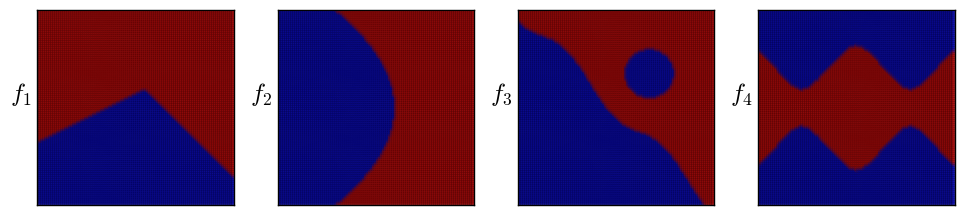

In [3]:
# Plot each function!
plt.figure(figsize=(9.75,2.25))
for i, y in enumerate([y1,y2,y3,y4]):
  plt.subplot(1,4,i+1)
  plt.xlim(-20,20)
  plt.ylim(-20,20)
  plt.xticks([])
  plt.yticks([])
  plt.ylabel('$f_'+str(i+1)+'$', fontsize=18, rotation=0, labelpad=12)
  vlim = np.abs(y).mean() * 0.5
  plt.scatter(X[:,0], X[:,1], c=y, alpha=0.2, cmap='bwr')
plt.tight_layout()
plt.show()

## Create an 8D train set whose labels can be decided by each function individually

Above, we created a uniformly spaced grid of 2D $x$ values, along with $y_i$ values describing where each of the functions $f_i$ are positive or negative.

Below, we'll create an 8D training dataset by uniformly sampling points where _all_ of the functions $f_i$ are positive or negative.

In [4]:
def joint_shuffle(X, y):
  idx = np.arange(len(y))
  np.random.shuffle(idx)
  return np.array(X)[idx], np.array(y)[idx]

# Compute indices in the grid where each function is positive and negative
y0_indices = [np.argwhere(1-y)[:,0] for y in [y1,y2,y3,y4]]
y1_indices = [np.argwhere( y )[:,0] for y in [y1,y2,y3,y4]]

# Construct an 8D dataset 
X_train = []
y_train = []
for i in range(25000):
  X_train.append(np.hstack([X[np.random.choice(idx)] for idx in y0_indices]))
  y_train.append(0)
  X_train.append(np.hstack([X[np.random.choice(idx)] for idx in y1_indices]))
  y_train.append(1)
  
X_train, y_train = joint_shuffle(X_train, y_train)

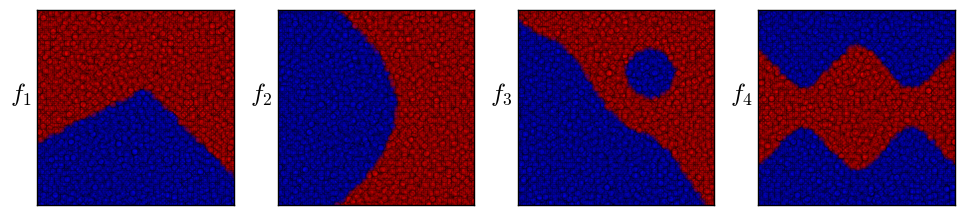

In [5]:
plt.figure(figsize=(9.75,2.25))
for i in range(4):
  plt.subplot(1,4,i+1)
  plt.xlim(-20,20)
  plt.ylim(-20,20)
  plt.xticks([])
  plt.yticks([])
  plt.ylabel('$f_'+str(i+1)+'$', fontsize=18, rotation=0, labelpad=12)
  plt.scatter(X_train[:,2*i], X_train[:,2*i+1], c=y_train, alpha=0.2, cmap='bwr')
plt.tight_layout()
plt.show()

## Create four versions of an 8D test set that only match one function

In [6]:
idx = np.arange(len(X))
X_test = np.array([np.hstack([X[np.random.choice(idx)] for i in range(4)]) for _ in range(25000)])
y_test1 = np.array([f1(*x)>0 for x in X_test[:,[0,1]]]).astype(float)
y_test2 = np.array([f2(*x)>0 for x in X_test[:,[2,3]]]).astype(float)
y_test3 = np.array([f3(*x)>0 for x in X_test[:,[4,5]]]).astype(float)
y_test4 = np.array([f4(*x)>0 for x in X_test[:,[6,7]]]).astype(float)

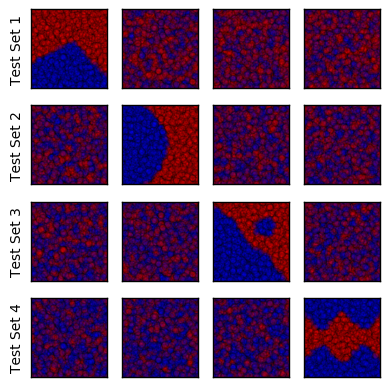

In [7]:
plt.figure(figsize=(4,4))
for j, y_test in enumerate([y_test1, y_test2, y_test3, y_test4]):
  for i in range(4):
    plt.subplot(4,4,i+1+j*4)
    plt.xlim(-20,20)
    plt.ylim(-20,20)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(X_test[:,2*i], X_test[:,2*i+1], c=y_test, alpha=0.2, cmap='bwr')
    if i == 0:
      plt.ylabel('Test Set {}'.format(j+1))
plt.tight_layout()
plt.show()

In this plot, each column shows the full dataset projected down to two dimensions (so the first column shows the projection of the dataset down to dimensions 1 and 2, the next column shows its projection down to dimensions 3 and 4, etc). If we can train an ensemble of models that matches these functions, then their predictions, projected down like this, should look similar.

## Define a neural network class

In [8]:
# Simple 2x256x256x2 ReLU network
class Net(NeuralNetwork):
  @property
  def x_shape(self):
    return [None, 8]
  
  @property
  def y_shape(self):
    return [None, 2]
  
  def rebuild_model(self, X, **_):
    L0 = X
    L1 = tf.layers.dense(L0, 256, name=self.name+'/L1', activation=tf.nn.relu)
    L2 = tf.layers.dense(L1, 256, name=self.name+'/L2', activation=tf.nn.relu)
    L3 = tf.layers.dense(L2,   2, name=self.name+'/L3', activation=None)
    return [L1, L2, L3] 

## Train a network normally and make predictions on the shared 8D test set

In [9]:
mlp1 = Net()
mlp1.fit(X_train, y_train, print_every=None)

In [10]:
preds1 = mlp1.predict(X_test)

## Train a diverse ensemble of four models and make predictions

Implementation note: to get consistent convergence, we had to train this ensemble for more epochs than a normal model, and decreasing the learning rate a little bit seemed to help as well. We include some debugging output so you can see how the cross entropy ("xent") and the cosine similarity penalty ("same") changed as we trained.

In [11]:
diverse_models = Net.train_diverse_models(4, X_train, y_train, learning_rate=0.0001, num_epochs=200, print_every=1000)

Batch 0, epoch 0, time 4.3s, acc1 0.2812, acc2 0.6133, acc3 0.3906, acc4 0.6016, same 1.7146, xent 5.3298
Batch 1000, epoch 5, time 34.1s, acc1 0.9766, acc2 0.9727, acc3 0.9492, acc4 0.9414, same 0.2779, xent 0.4520
Batch 2000, epoch 10, time 63.5s, acc1 0.9883, acc2 0.9922, acc3 0.9766, acc4 0.9766, same 0.2068, xent 0.2134
Batch 3000, epoch 15, time 92.9s, acc1 0.9727, acc2 0.9922, acc3 0.9805, acc4 0.9609, same 0.2424, xent 0.2439
Batch 4000, epoch 20, time 121.9s, acc1 0.9844, acc2 0.9961, acc3 0.9688, acc4 0.9648, same 0.2347, xent 0.2142
Batch 5000, epoch 25, time 150.1s, acc1 0.9844, acc2 0.9922, acc3 0.9883, acc4 0.9844, same 0.1701, xent 0.1462
Batch 6000, epoch 30, time 178.0s, acc1 0.9883, acc2 1.0000, acc3 1.0000, acc4 0.9648, same 0.1805, xent 0.1671
Batch 7000, epoch 35, time 203.4s, acc1 0.9688, acc2 1.0000, acc3 0.9883, acc4 0.9844, same 0.1564, xent 0.1406
Batch 8000, epoch 40, time 230.3s, acc1 1.0000, acc2 0.9961, acc3 0.9961, acc4 0.9883, same 0.1346, xent 0.0904
Ba

In [12]:
preds_by_model = [mlp.predict(X_test) for mlp in diverse_models]

In [13]:
# Define a plotting helper to better visualize predictions projected down to 2 dimensions
def predshow(preds, label=None, cbar=False, label_right=False):
  stats_2d_1 = binned_statistic_2d(X_test[:,0], X_test[:,1], preds, bins=20)
  stats_2d_2 = binned_statistic_2d(X_test[:,2], X_test[:,3], preds, bins=20)
  stats_2d_3 = binned_statistic_2d(X_test[:,4], X_test[:,5], preds, bins=20)
  stats_2d_4 = binned_statistic_2d(X_test[:,6], X_test[:,7], preds, bins=20)
  yts = [y_test1,y_test2,y_test3,y_test4]
  norm = Normalize(vmin=0, vmax=1)
  for i,s in enumerate([stats_2d_1, stats_2d_2, stats_2d_3, stats_2d_4]):
    plt.subplot(1,4,i+1)
    if label and not i:
      if label_right:
        plt.gcf().text(0.9, 0.51, label, rotation='horizontal', ha='left', va='center')
      else:
        plt.gcf().text(0.1, 0.51, label, rotation='horizontal', ha='right', va='center')
    acc = np.mean(preds == yts[i])
    im = plt.imshow(np.fliplr(s.statistic).T, interpolation='none', norm=norm)
    plt.title('Acc: {:.0%}'.format(acc), fontsize=10)
    plt.axis('off')
  if cbar:
    fig = plt.gcf()
    fig.subplots_adjust(right=0.9)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.75])
    fig.colorbar(im, cax=cbar_ax, ticks=[0,0.5,1.0])
  plt.show()

## Visualize how those predictions vary when we project our 8D dataset down to each 2D slice

(Also plot how well our predictions would have done on the corresponding test set that only matches one function)

In [14]:
# Reorder models to make for a nicer figure
def reord(arr, idxes):
  return [arr[i] for i in idxes]

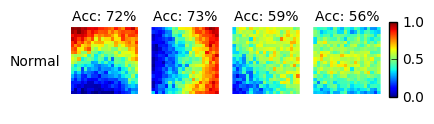

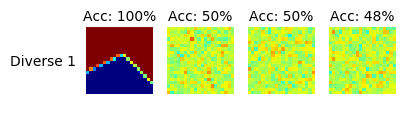

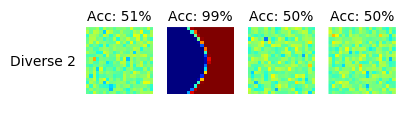

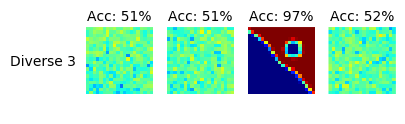

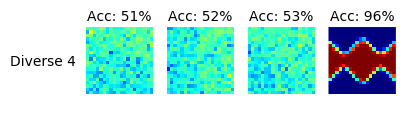

In [23]:
plt.figure(figsize=(4,1))
predshow(preds1, label='Normal', cbar=True)
for i, pred in enumerate(reord(preds_by_model, [1,0,2,3]), 1):
  fig = plt.figure(figsize=(4,1))
  predshow(pred, label='Diverse {}'.format(i))

So, these plots are similar to the scatterplots of the four functions we showed above, but instead of scatterplotting all the points, we divide each 2D plane into square bins and compute the average prediction in that bin (for the 8D dataset, projected down into it); that is used to compute the color of a corresponding pixel.

If the model has "learned" one and only one function, we should expect pixels to be totally blue/red (~0 or 1) in one of the images, and completely yellow/green (~0.5) in the rest. We should also expect accuracy on the test set corresponding to that function to be near 100% and accuracy on the other test sets to be near 50%. If the model has "learned" _multiple_ functions, we should expect it to be _partially_ blue/red in multiple images. We should also expect accuracy well above 50% but well below 100% on multiple test sets.

The conclusion we can draw from these plots is that the normal model learns multiple functions, but the members of the diverse ensemble each learn only one.

Does this make the members of our ensemble more "interpretable" than a normally trained model? Well, it depends on your definition of interpretable, but we think that the answer will be yes for most reasonable definitions of the term.

## Examining predictions from other model classes

One point we would like to emphasize is that this tendency of normally trained (empirical risk minimizing) models to learn a dense combination of many possible independent decision rules isn't unique to neural networks; it also afflicts model classes widely considered to be "interpretable," such as logistic regression models and decision trees:

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

non_neural_models = []
for model_class in [LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, SVC]:
  model = model_class()
  model.fit(X_train, y_train)
  non_neural_models.append(model)
  print('{} train accuracy: {:.1%}'.format(model.__class__.__name__, model.score(X_train, y_train)))

LogisticRegression train accuracy: 99.2%
DecisionTreeClassifier train accuracy: 100.0%
RandomForestClassifier train accuracy: 100.0%
SVC train accuracy: 100.0%


In [17]:
non_neural_preds = [(model.predict(X_test)>0).astype(int) for model in non_neural_models]

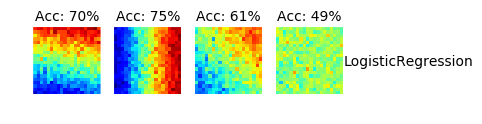

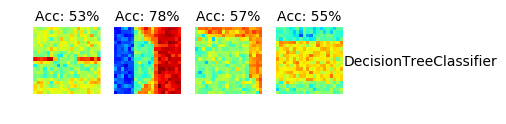

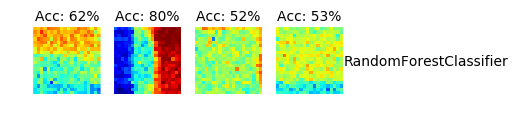

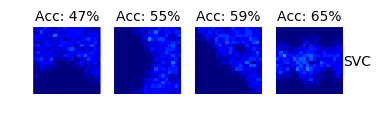

In [18]:
for model, pred in zip(non_neural_models, non_neural_preds):
  fig = plt.figure(figsize=(4,1))
  predshow(pred, label=model.__class__.__name__, label_right=True)

Although our dataset remains quite simple in this example, the model instances we learn with these model classes are all fairly difficult to reason about; imagine for yourself whether, for any of these models, you can easily simulate how it will behave on a new point in your head.

It's quite possible that these problems, these barriers to interpretability, only become worse on higher-dimensional datasets.

## More Visualizations of Diverse Functions

### Input Gradients

Let's look at input gradients, a common measurement of feature saliency, for each of the functions we learn:

In [19]:
grads1 = mlp1.input_gradients(X_test, logits=True)

In [20]:
grads_div = [mlp.input_gradients(X_test, logits=True) for mlp in diverse_models]

/Users/asross/.pyenv/versions/3.5.1/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


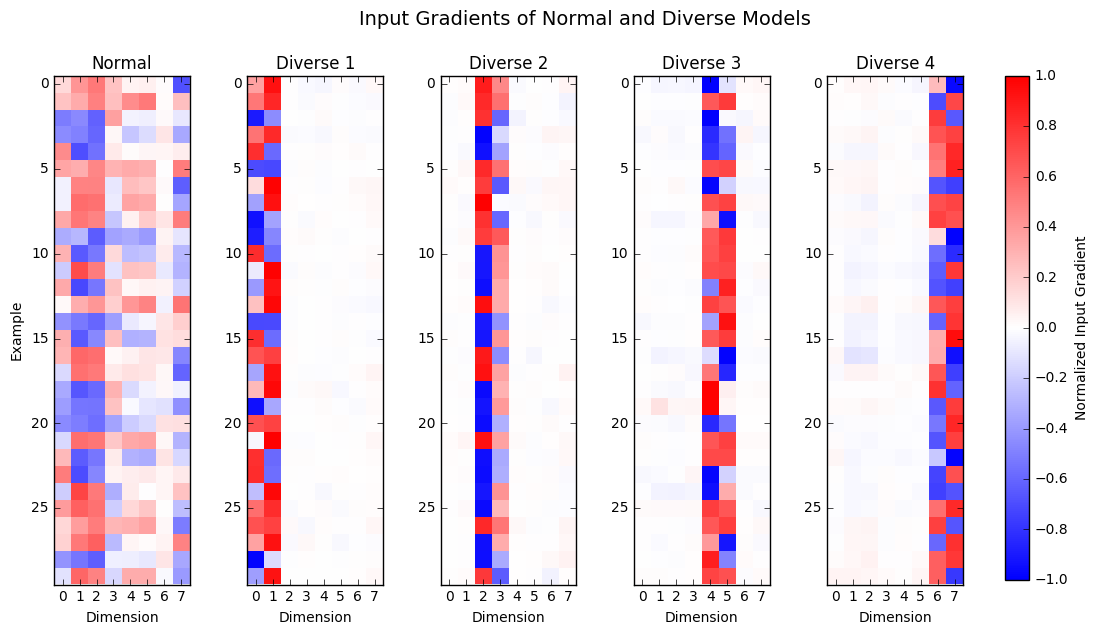

In [24]:
def normalize(grads):
  return np.array([g/np.linalg.norm(g) for g in grads])

from figure_grid import *

with figure_grid(1,6,rowwidth=12,rowheight=6) as g:
  g.title('Input Gradients of Normal and Diverse Models')
  g.next()
  plt.imshow(normalize(grads1[:30]), vmin=-1, vmax=1, interpolation='none', cmap='bwr')
  plt.title('Normal')
  plt.xlabel('Dimension')
  plt.ylabel('Example')
  for i in range(4):
    g.next()
    im = plt.imshow(normalize(grads_div[[1,0,2,3][i]][:30]), vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.title('Diverse {}'.format(i+1))
    plt.xlabel('Dimension')
  cbaxes = g.fig.add_axes([0.85, 0.1, 0.02, 0.84]) 
  g.fig.colorbar(im, label='Normalized Input Gradient', cax=cbaxes)

Here each row in each image represents a different example from the test set, while each column a dimension of $x$. We normalize each gradient to have L2 norm equal to 1, and plot component values.

From this diagram it's clear that the normal model is highly sensitive to almost all dimensions, while each of the diverse models is mostly sensitive to only a single pair of dimensions.

### Local Mutual Information

Here we'll estimate the local mutual information between two functions that we've learned (specifically, the mutual information between functions evaluated at small Gaussian perturbations of an input). Because our space is 8-dimensional, doing this over a grid would be impractical, but we can instead just estimate the local mutual information at random points in 8D space.

In [25]:
# Although evaluating the statistical dependence of two trained neural networks
# is difficult analytically, it's easy to estimate if we approximate the joint
# and marginals by histograms:
def estimate_mutual_information(f1_vals, f2_vals, bins=20):
  from sklearn.metrics import mutual_info_score
  hist = np.histogram2d(f1_vals, f2_vals, bins)[0] # approximate joint
  info = mutual_info_score(None, None, contingency=hist)
  return info / np.log(2) # bits

def estimate_local_mutual_info(x, f1, f2, sigma=0.001, n_samples=10000, sess=None):
  samples = np.random.multivariate_normal(x, sigma * np.eye(len(x)), size=(n_samples,))
  fn_vals = [f.batch_eval(sess, f.binary_logits, samples, n=1000) for f in [f1,f2]]
  return estimate_mutual_information(*fn_vals)

In [26]:
xes = [np.random.multivariate_normal(np.zeros(8), 20*np.eye(8)) for _ in range(9)]
funcs = [mlp1] + diverse_models

In [27]:
with tf.Session() as sess:
  for f in funcs: f.init(sess)
  mutual_infos = [[[estimate_local_mutual_info(x, f1, f2, sess=sess) for f1 in funcs] for f2 in funcs] for x in xes]

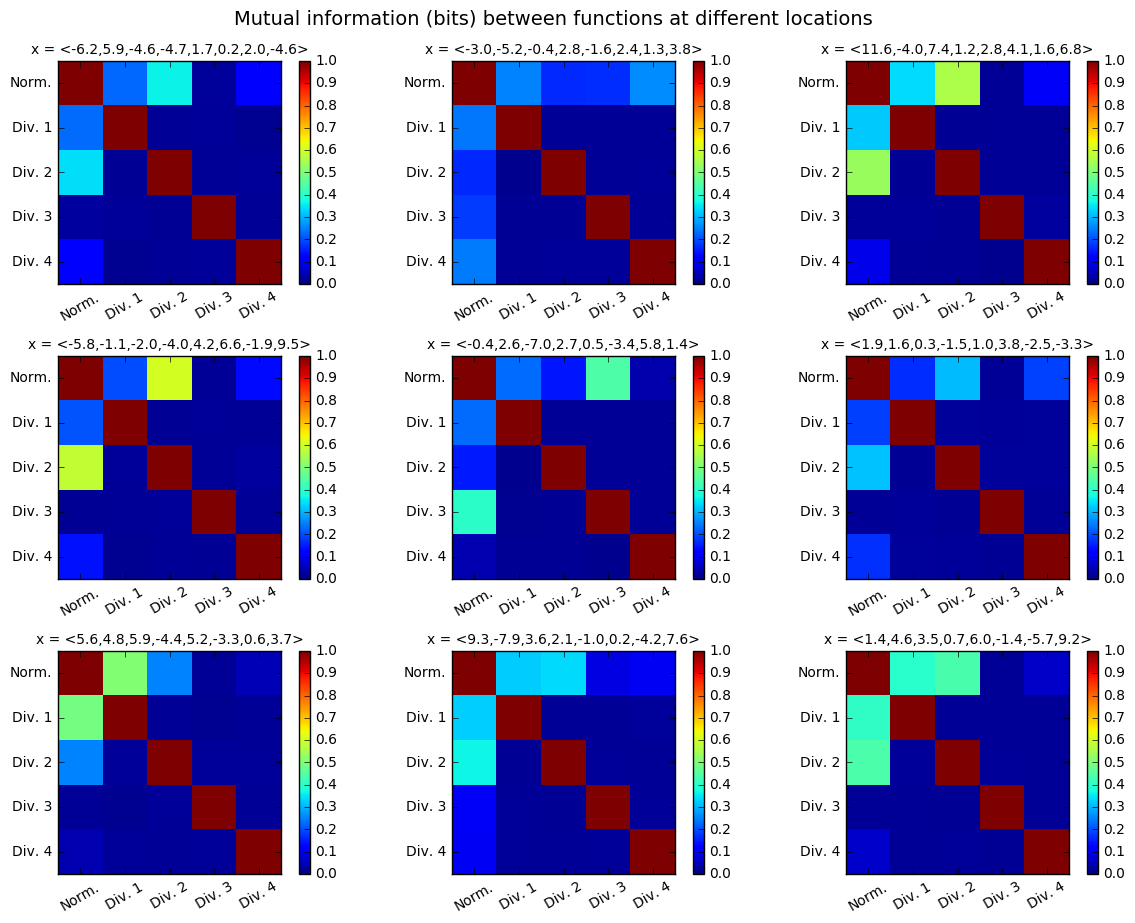

In [28]:
labels = ['Norm.','Div. 1','Div. 2','Div. 3','Div. 4']

def pp(x, to=1):
  xs = [str(xi.round(to)) for xi in x]
  return '<' + ','.join(xs) + '>'

with figure_grid(3,3) as g:
  g.title('Mutual information (bits) between functions at different locations', y=1.02)
  for i, mis in enumerate(mutual_infos):
    g.next()
    plt.title('x = {}'.format(pp(xes[i])), fontsize=10)
    plt.imshow(mis, interpolation='none', vmin=0, vmax=1)
    plt.xticks(range(len(labels)), labels, rotation=30)
    plt.yticks(range(len(labels)), labels)
    plt.colorbar()

We can see that all of the diverse functions are locally independent, at least at these samples, while the normally trained model has local statistical dependency on all of them. And importantly, this local dependence _changes_ at different points in input space. This makes the normally trained model much more difficult to simulate; while it's pretty easy to intuitively understand how all of the diverse functions will behave on new inputs, it's difficult if not impossible to do the same thing for the normally trained model.